# Imports


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36
LIMIT = 5000

USE_CONTROL_SET = True

In [2]:
try:
    LIMIT = int(LIMIT)
except:
    LIMIT = 5000
        
 
print(f'{LIMIT=}')



COLLECTION_NAME = 'documents'
if USE_CONTROL_SET:
    COLLECTION_NAME = 'documents_temp'
    
print(f'{COLLECTION_NAME=}')

LIMIT=5000
COLLECTION_NAME='documents_temp'


In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os

import tensorflow as tf

logger = logging.getLogger('export_ts')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-04-18 11:08:27.237964: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-04-18 11:08:27,828 - export_ts - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.4.14
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

#3rd party--------
import json
import re
import pandas as pd
import numpy as np

from pandas import DataFrame
from pathlib import Path

from datetime import datetime
from datetime import date

from math import log1p
from pandas import DataFrame


from pathlib import Path

from bson import ObjectId
from bson import json_util


from dateutil.relativedelta import relativedelta

from pymongo import ASCENDING
 

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

from collections import Counter



#ours---------

 
from analyser.persistence import DbJsonDoc
from analyser.structures import DocumentState
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph, embedd_tokens
from analyser.ml_tools import SemanticTag
from analyser.headers_detector import get_tokens_features

from integration.db import get_mongodb_connection
from integration.word_document_parser import join_paragraphs

from colab_support.renderer import plot_embedding

from tf_support.embedder_elmo import ElmoEmbedder
from tf_support.super_contract_model import get_semantic_map_new, t_semantic_map_keys_price
from tf_support.super_contract_model import semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org





[documents.py:271 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:28 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
def get_doc_from_db_by_id (objid):
    db = get_mongodb_connection()
    documents_collection = db[COLLECTION_NAME]
    _id = ObjectId(str(objid))
    jdata = documents_collection.find_one({'_id': _id})
    return jdata
    # return DbJsonDoc(jdata)





### Init ml flow

In [8]:
import mlflow
 
ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')
mlflow.set_experiment("Анализатор: экспорт данных из mongo")
             

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


<Experiment: artifact_location='mlflow-artifacts:/273381584422389923', creation_time=1680874514048, experiment_id='273381584422389923', last_update_time=1681801947445, lifecycle_stage='active', name='Анализатор: экспорт данных из mongo', tags={}>

### Prepare workdir

In [9]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'


assert os.path.isdir(analyser.hyperparams.work_dir)

In [10]:


NOTEBOOKS_DIR = str(Path(analyser.__file__).parent.parent/'trainsets')
print(f'{LIMIT=}')
print(f'{NOTEBOOKS_DIR=}')
print(f'{analyser.hyperparams.work_dir=}', )
print(f'{reports_path=}', )

LIMIT=5000
NOTEBOOKS_DIR='/root/artem/analyser/trainsets'
analyser.hyperparams.work_dir=PosixPath('/root/artem/work')
reports_path=PosixPath('/root/artem/analyser/training_reports')


### Query DB for contact IDs

#### Load meta data CSV

In [11]:
contract_trainset_meta_fn = 'contract_trainset_meta.temp.csv'
if USE_CONTROL_SET:
    contract_trainset_meta_fn = 'contract_trainset_meta.control.temp.csv'
    
export_fn = str(Path(work_dir) / contract_trainset_meta_fn)

In [12]:
!touch {export_fn}
# !tail {export_fn}

In [13]:


# stats = pd.read_csv(export_fn, index_col=0)
mlflow.log_param('metafile',  export_fn)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
    mlflow.log_param('last_doc_export_date',  lastdate)
    mlflow.log_metric('docs_in_metafile_start',  len(stats))
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    # stats = stats.astype({'currency':str})
    stats['currency']=''
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'


lastdate=2023-04-07 12:23:57.628000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.control.temp.csv


In [14]:
 
display(Markdown(f"#### {lastdate:%d.%m.%Y} -- дата последнего экспортированного документа"))


#### 07.04.2023 -- дата последнего экспортированного документа

# functions

In [15]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  stats.at[_id, 'value'] = None
  stats.at[_id, 'value_log1p'] = None
  stats.at[_id, 'value_span'] = None
  stats.at[_id, 'currency'] = None
    
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
    
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      if _orgs[0]:
          stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
          stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')
          stats.at[_id, 'org-1-type'] = _orgs[0].get('type', {}).get('value')

      if len(_orgs)>1:
          if _orgs[1]:
            stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
            stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')
            stats.at[_id, 'org-2-type'] = _orgs[1].get('type', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  stats.at[_id, 'user_correction_date'] = None
  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)

    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in d.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


# d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
# jd = DbJsonDoc(d)
# add_stats_record(jd, stats)
# stats.loc['5fe34f62b770574a005553be']

# load legacy json

In [16]:
_DEBUG = False

if not USE_CONTROL_SET:

    file_data=None

    try:
        fn = work_dir / 'documents.json'
        with open(fn) as file:
            file_data = json.load(file, object_hook=json_util.object_hook)

            print(f'total docs in {fn} is {len(file_data)}')    
  
    except Exception as ex:
        logger.exception(ex)    

    if _DEBUG:
        a_doc_from_json=DbJsonDoc(file_data[3])

        print(a_doc_from_json.get_attributes_tree())
        print(a_doc_from_json.get_version_string())

In [17]:

# TODO: import!!!



print("semantic_map_keys_contract", semantic_map_keys_contract)

 

if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:150], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


In [18]:
_DEBUG

False

In [19]:
#test one
from analyser.headers_detector import get_tokens_features

if _DEBUG:
    d = get_doc_from_db_by_id(ObjectId('636dfd1473925c8dae26f910'))
    if d is not None:
        jd = DbJsonDoc(d)
        semantic_map: DataFrame = get_semantic_map_new(jd)

        tokens_features = get_tokens_features(jd.get_tokens_map_unchaged().tokens)

        plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')
        plot_embedding(tokens_features, f'tokens')

In [20]:
# tokens_features

### Adding data from old json file to the stats table

In [21]:
# fff
files_dict = {}
files_cnt = 0

if not USE_CONTROL_SET:
    
    if file_data:
        k=0
        for d in file_data:
            k+=1 
            jd = DbJsonDoc(d)
        #     print( jd.analysis['analyze_timestamp'])
            files_dict[jd.get_id()] = jd
            try:            
                add_stats_record(jd, stats, source = 'file')
                files_cnt+=1
            except Exception as e:
                print(e)
                print(jd.get_id())
    #             raise (e)

            if k % 100 == 0:

                print(f'{k} of {len(file_data)}')
                stats.to_csv(export_fn, index=True)
                print(f'stats saved to {export_fn}')


    mlflow.log_param('files_in_json',  files_cnt)            
    stats.to_csv(export_fn, index=True)
 


print(f'stats saved to {export_fn}')

# del file_data
stats




stats saved to /root/artem/work/contract_trainset_meta.control.temp.csv


,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos
643831490fcb1a83bb18af04,RUB,db,ce18665839e043a6ce4509a637206f8f,1.6.5,CONTRACT,2023-04-18 09:43:49.336628,14429.0,2020-05-18 18:07:51.823000+00:00,15.0,1.500000e+09,...,Акционерное общество,Сатурн,Исполнитель,Общество с ограниченной ответственностью,Service,1.0,54.0,2023-02-11 20:29:12.536000+00:00,True,186.0
643831490fcb1a83bb18aeb0,NaN,db,88f5da52483e2e85fadc96d51ef17162,1.6.5,CONTRACT,2023-04-18 09:43:49.465735,12872.0,2020-05-18 18:33:17.208000+00:00,32.0,NaN,...,Общество с ограниченной ответственностью,Ромашка,Поставщик,Общество с ограниченной ответственностью,Deal,1.0,44.0,2023-02-28 09:23:22.239000+00:00,True,121.0
643831490fcb1a83bb18ae41,NaN,db,f1212043d115de6f0692f16f9d4f2fad,1.6.5,CONTRACT,2023-04-18 09:43:49.590483,12866.0,2020-05-18 18:39:44.742000+00:00,32.0,NaN,...,Общество с ограниченной ответственностью,Ромашка,Поставщик,Общество с ограниченной ответственностью,Deal,1.0,44.0,2023-02-08 07:56:54.646000+00:00,True,116.0
643831490fcb1a83bb18af05,RUB,db,a3bd7285f7fa43a3e43ba02f48b94f2c,1.6.5,CONTRACT,2023-04-18 09:43:49.605542,2957.0,2020-05-21 10:37:37.826000+00:00,17.0,5.900000e+07,...,Акционерное общество,Ромашка,Покупатель,Общество с ограниченной ответственностью,RealEstateTransactions,0.0,38.0,2020-05-21 10:35:38.284000+00:00,True,107.0
643831490fcb1a83bb18ae95,NaN,db,ce4624bf7b3b1f8981d2691897b50597,1.6.5,CONTRACT,2023-04-18 09:43:49.629459,5235.0,2020-05-21 10:48:18.378000+00:00,19.0,NaN,...,Общество с ограниченной ответственностью,Радуга,Арендодатель,Общество с ограниченной ответственностью,Renting,1.0,32.0,2023-02-21 13:10:39.175000+00:00,True,902.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18aec6,RUB,db,520b6d634f9dbf34a17c084f55ff7694,23.01.23,CONTRACT,2023-04-18 09:43:58.172471,951.0,2023-03-10 10:39:54.036000+00:00,9.0,1.500000e+07,...,Общество с ограниченной ответственностью,Ромашка,Продавец,Акционерное общество,SecuritiesTransactions,1.0,48.0,2023-03-13 08:28:39.222000+00:00,True,94.0
643831490fcb1a83bb18ade6,RUB,db,239111df7c0c34d7b1a928396370f963,23.3.11,CONTRACT,2023-04-18 09:43:58.227052,8788.0,2023-03-11 07:53:45.466000+00:00,24.0,5.560251e+07,...,Общество с безграничной ответственностью,Лютик,Подрядчик,Общество с ограниченной ответственностью,GeneralContract,1.0,45.0,2023-03-11 04:57:42.291000+00:00,True,1309.0
643831490fcb1a83bb18ae14,RUB,db,b947d554a5fb2a990c0645742dedbfd1,23.3.11,CONTRACT,2023-04-18 09:43:58.336862,12548.0,2023-03-11 07:54:24.555000+00:00,42.0,1.221254e+06,...,Общество с ограниченной ответственностью,Ромашка,Субподрядчик,Общество с ограниченной ответственностью,GeneralContract,1.0,39.0,2023-03-11 09:45:45.442000+00:00,True,975.0
643831490fcb1a83bb18ae25,RUB,db,9756e819859af5192b5e44806f173d8c,23.3.11,CONTRACT,2023-04-18 09:43:58.343962,1953.0,2023-03-11 07:54:54.789000+00:00,10.0,5.000000e+02,...,Общество с ограниченной ответственностью,Клуб «Лютик»,Клуб,Ассоциация,Service,1.0,55.0,2023-03-11 09:36:56.495000+00:00,True,416.0


In [22]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos


In [23]:
if not USE_CONTROL_SET:
    invalid = stats[stats['valid']==False]
    print(f'{len(invalid)}: number of invalid records')
    mlflow.log_metric('invalid records',  len(invalid))     
    invalid

# Fetch fresh docs from Mongo DB

In [24]:

# from datetime import timedelta
# if True:

lastdate  += relativedelta(days=-15)  
# lastdate = datetime.combine(lastdate, datetime.min.time())
# lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-03-23 12:23:57.628000+0000', tz='UTC')

In [25]:
report_date = datetime.now() + relativedelta(days=-2)  
report_date

datetime.datetime(2023, 4, 16, 11, 8, 30, 551426)

In [26]:
yesterday = datetime.now() + relativedelta(days=-1)  
# {'analysis.analyze_timestamp': {'$gt': yesterday}},




 
query = {'user.updateDate': {'$gt': report_date}}

db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]

sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(LIMIT)

_r = list([i for i in res])
# print(res[0])
_s = f"#### {len(_r)} -- всего размечено документов после {report_date:%d.%m.%Y}"
mlflow.log_metric('fresh_user_docs_in_db',  len(_r))     
mlflow.log_param('db_docs_collection',  COLLECTION_NAME)     
display(Markdown(_s))
yseterday_ids=[i["_id"] for i in _r]


DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

#### 0 -- всего размечено документов после 16.04.2023

In [27]:


if USE_CONTROL_SET:
    query = {
      '$and': [
        {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
        { 'subset': 'CONTROL_TRAIN'},
 
        {'$or': [
              {"analysis.attributes_tree": {"$ne": None}},
              {"user.attributes_tree": {"$ne": None}}
            ]},
 
        {'$or': [
          {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
          {'user.updateDate': {'$gt': lastdate}}
        ]}
      ]
    }
    
 
    
else:
    query = {
      '$and': [
        {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },

 
        {'$or': [
              {"analysis.attributes_tree": {"$ne": None}},
              {"user.attributes_tree": {"$ne": None}}
            ]},
 
        {'$or': [
          {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
          {'user.updateDate': {'$gt': lastdate}}
        ]}
      ]
    }

db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(LIMIT)

res = list([i for i in res])
mlflow.log_metric('fresh_docs_in_db',  len(res))     
# print(res[0])
_s = f"#### {len(res)} -- всего проанализировано новых документов после {lastdate:%d.%m.%Y}"
display(Markdown(_s))

res[:4]

#### 1 -- всего проанализировано новых документов после 23.03.2023

[{'_id': ObjectId('643831490fcb1a83bb18ae1a'),
  'user': {'updateDate': datetime.datetime(2023, 4, 7, 9, 25, 13, 206000)},
  'state': 12,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [28]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(f"{len(new_docs_ids)=}")


len(new_docs_ids)=1


In [29]:
stats.columns

Index(['currency', 'source', 'checksum', 'version', 'documentType',
       'export_date', 'len', 'analyze_date', 'headers', 'value', 'value_log1p',
       'value_span', 'org-1-name', 'org-1-alias', 'org-1-type', 'org-2-name',
       'org-2-alias', 'org-2-type', 'subject', 'subject confidence',
       'subj_len', 'user_correction_date', 'valid', 'subject_pos'],
      dtype='object')

In [30]:
def add_to_stats_list(docs_ids, stats):
    for k, oid in enumerate(docs_ids):
        d = get_doc_from_db_by_id( str(oid))
        jd = None
        try:
            jd = DbJsonDoc(d)            
        except Exception as e:
            print(f'missing {oid=}')
            stats = stats.drop(index=oid)
            logger.exception (e)
        
        if jd:
            add_stats_record(jd, stats)
            
        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
   


add_to_stats_list(new_docs_ids, stats)     

stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
mlflow.log_metric('docs_in_metafile_result',  len(stats))


0 of 1
stats saved to /root/artem/work/contract_trainset_meta.control.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.control.temp.csv


In [31]:
stats

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos
643831490fcb1a83bb18af04,RUB,db,ce18665839e043a6ce4509a637206f8f,1.6.5,CONTRACT,2023-04-18 09:43:49.336628,14429.0,2020-05-18 18:07:51.823000+00:00,15.0,1.500000e+09,...,Акционерное общество,Сатурн,Исполнитель,Общество с ограниченной ответственностью,Service,1.0,54.0,2023-02-11 20:29:12.536000+00:00,True,186.0
643831490fcb1a83bb18aeb0,NaN,db,88f5da52483e2e85fadc96d51ef17162,1.6.5,CONTRACT,2023-04-18 09:43:49.465735,12872.0,2020-05-18 18:33:17.208000+00:00,32.0,NaN,...,Общество с ограниченной ответственностью,Ромашка,Поставщик,Общество с ограниченной ответственностью,Deal,1.0,44.0,2023-02-28 09:23:22.239000+00:00,True,121.0
643831490fcb1a83bb18ae41,NaN,db,f1212043d115de6f0692f16f9d4f2fad,1.6.5,CONTRACT,2023-04-18 09:43:49.590483,12866.0,2020-05-18 18:39:44.742000+00:00,32.0,NaN,...,Общество с ограниченной ответственностью,Ромашка,Поставщик,Общество с ограниченной ответственностью,Deal,1.0,44.0,2023-02-08 07:56:54.646000+00:00,True,116.0
643831490fcb1a83bb18af05,RUB,db,a3bd7285f7fa43a3e43ba02f48b94f2c,1.6.5,CONTRACT,2023-04-18 09:43:49.605542,2957.0,2020-05-21 10:37:37.826000+00:00,17.0,5.900000e+07,...,Акционерное общество,Ромашка,Покупатель,Общество с ограниченной ответственностью,RealEstateTransactions,0.0,38.0,2020-05-21 10:35:38.284000+00:00,True,107.0
643831490fcb1a83bb18ae95,NaN,db,ce4624bf7b3b1f8981d2691897b50597,1.6.5,CONTRACT,2023-04-18 09:43:49.629459,5235.0,2020-05-21 10:48:18.378000+00:00,19.0,NaN,...,Общество с ограниченной ответственностью,Радуга,Арендодатель,Общество с ограниченной ответственностью,Renting,1.0,32.0,2023-02-21 13:10:39.175000+00:00,True,902.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18aec6,RUB,db,520b6d634f9dbf34a17c084f55ff7694,23.01.23,CONTRACT,2023-04-18 09:43:58.172471,951.0,2023-03-10 10:39:54.036000+00:00,9.0,1.500000e+07,...,Общество с ограниченной ответственностью,Ромашка,Продавец,Акционерное общество,SecuritiesTransactions,1.0,48.0,2023-03-13 08:28:39.222000+00:00,True,94.0
643831490fcb1a83bb18ade6,RUB,db,239111df7c0c34d7b1a928396370f963,23.3.11,CONTRACT,2023-04-18 09:43:58.227052,8788.0,2023-03-11 07:53:45.466000+00:00,24.0,5.560251e+07,...,Общество с безграничной ответственностью,Лютик,Подрядчик,Общество с ограниченной ответственностью,GeneralContract,1.0,45.0,2023-03-11 04:57:42.291000+00:00,True,1309.0
643831490fcb1a83bb18ae14,RUB,db,b947d554a5fb2a990c0645742dedbfd1,23.3.11,CONTRACT,2023-04-18 09:43:58.336862,12548.0,2023-03-11 07:54:24.555000+00:00,42.0,1.221254e+06,...,Общество с ограниченной ответственностью,Ромашка,Субподрядчик,Общество с ограниченной ответственностью,GeneralContract,1.0,39.0,2023-03-11 09:45:45.442000+00:00,True,975.0
643831490fcb1a83bb18ae25,RUB,db,9756e819859af5192b5e44806f173d8c,23.3.11,CONTRACT,2023-04-18 09:43:58.343962,1953.0,2023-03-11 07:54:54.789000+00:00,10.0,5.000000e+02,...,Общество с ограниченной ответственностью,Клуб «Лютик»,Клуб,Ассоциация,Service,1.0,55.0,2023-03-11 09:36:56.495000+00:00,True,416.0


## Fixing missing Headers [legacy]

In [32]:
s = stats[ stats['source']=='db'] 
s =s[s['headers'].isna()]
 
_ids = list(s.index)
print(len(_ids))
 
del _ids
s

0


,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos


In [33]:
stats = stats[stats.valid!=False]
len(stats)

185

### Put all to lower

In [34]:
stats2 = stats.copy()

if False:
    for i in (1,2):
        for key in ['alias', 'name', 'type']:
            k=f'org-{i}-{key}'
            stats2[k] = stats2[k].str.lower()
        
        
# stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
# stats2['org-1-name'] = stats2['org-1-name'].str.lower()
# stats2['org-2-name'] = stats2['org-2-name'].str.lower()

# stats2['org-1-type'] = stats2['org-1-type'].str.lower()
# stats2['org-2-type'] = stats2['org-2-type'].str.lower()
stats2

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos
643831490fcb1a83bb18af04,RUB,db,ce18665839e043a6ce4509a637206f8f,1.6.5,CONTRACT,2023-04-18 09:43:49.336628,14429.0,2020-05-18 18:07:51.823000+00:00,15.0,1.500000e+09,...,Акционерное общество,Сатурн,Исполнитель,Общество с ограниченной ответственностью,Service,1.0,54.0,2023-02-11 20:29:12.536000+00:00,True,186.0
643831490fcb1a83bb18aeb0,NaN,db,88f5da52483e2e85fadc96d51ef17162,1.6.5,CONTRACT,2023-04-18 09:43:49.465735,12872.0,2020-05-18 18:33:17.208000+00:00,32.0,NaN,...,Общество с ограниченной ответственностью,Ромашка,Поставщик,Общество с ограниченной ответственностью,Deal,1.0,44.0,2023-02-28 09:23:22.239000+00:00,True,121.0
643831490fcb1a83bb18ae41,NaN,db,f1212043d115de6f0692f16f9d4f2fad,1.6.5,CONTRACT,2023-04-18 09:43:49.590483,12866.0,2020-05-18 18:39:44.742000+00:00,32.0,NaN,...,Общество с ограниченной ответственностью,Ромашка,Поставщик,Общество с ограниченной ответственностью,Deal,1.0,44.0,2023-02-08 07:56:54.646000+00:00,True,116.0
643831490fcb1a83bb18af05,RUB,db,a3bd7285f7fa43a3e43ba02f48b94f2c,1.6.5,CONTRACT,2023-04-18 09:43:49.605542,2957.0,2020-05-21 10:37:37.826000+00:00,17.0,5.900000e+07,...,Акционерное общество,Ромашка,Покупатель,Общество с ограниченной ответственностью,RealEstateTransactions,0.0,38.0,2020-05-21 10:35:38.284000+00:00,True,107.0
643831490fcb1a83bb18ae95,NaN,db,ce4624bf7b3b1f8981d2691897b50597,1.6.5,CONTRACT,2023-04-18 09:43:49.629459,5235.0,2020-05-21 10:48:18.378000+00:00,19.0,NaN,...,Общество с ограниченной ответственностью,Радуга,Арендодатель,Общество с ограниченной ответственностью,Renting,1.0,32.0,2023-02-21 13:10:39.175000+00:00,True,902.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18aec6,RUB,db,520b6d634f9dbf34a17c084f55ff7694,23.01.23,CONTRACT,2023-04-18 09:43:58.172471,951.0,2023-03-10 10:39:54.036000+00:00,9.0,1.500000e+07,...,Общество с ограниченной ответственностью,Ромашка,Продавец,Акционерное общество,SecuritiesTransactions,1.0,48.0,2023-03-13 08:28:39.222000+00:00,True,94.0
643831490fcb1a83bb18ade6,RUB,db,239111df7c0c34d7b1a928396370f963,23.3.11,CONTRACT,2023-04-18 09:43:58.227052,8788.0,2023-03-11 07:53:45.466000+00:00,24.0,5.560251e+07,...,Общество с безграничной ответственностью,Лютик,Подрядчик,Общество с ограниченной ответственностью,GeneralContract,1.0,45.0,2023-03-11 04:57:42.291000+00:00,True,1309.0
643831490fcb1a83bb18ae14,RUB,db,b947d554a5fb2a990c0645742dedbfd1,23.3.11,CONTRACT,2023-04-18 09:43:58.336862,12548.0,2023-03-11 07:54:24.555000+00:00,42.0,1.221254e+06,...,Общество с ограниченной ответственностью,Ромашка,Субподрядчик,Общество с ограниченной ответственностью,GeneralContract,1.0,39.0,2023-03-11 09:45:45.442000+00:00,True,975.0
643831490fcb1a83bb18ae25,RUB,db,9756e819859af5192b5e44806f173d8c,23.3.11,CONTRACT,2023-04-18 09:43:58.343962,1953.0,2023-03-11 07:54:54.789000+00:00,10.0,5.000000e+02,...,Общество с ограниченной ответственностью,Клуб «Лютик»,Клуб,Ассоциация,Service,1.0,55.0,2023-03-11 09:36:56.495000+00:00,True,416.0


# Statistics
### Collecting org types

In [35]:
stats2['subject'].value_counts()

Service                              64
GeneralContract                      26
Loans                                23
Deal                                 15
Renting                              13
DealIntellectualProperty             11
SecuritiesTransactions                9
Charity                               7
ParticipationInOtherOrganizations     6
AgencyContract                        4
RealEstate                            4
RealEstateTransactions                3
Name: subject, dtype: int64

In [36]:
stats2['org-1-alias'].value_counts()

Заказчик                        58
Покупатель                      14
Исполнитель                     12
Продавец                        12
ЗАКАЗЧИК                        11
Заемщик                          9
Заявитель                        8
Арендатор                        7
Арендодатель                     5
Лицензиат                        5
Благотворитель                   5
Поставщик                        5
Займодавец                       4
Эмитент                          3
Агент                            3
Генподрядчик                     3
Кредитор                         3
Подрядчик                        2
Энергоснабжающая организация     2
Организатор                      1
Лицензиар                        1
Ромашка                          1
ООО «Ромашка»                    1
Клиент                           1
Сторона                          1
Субарендодатель                  1
ПРОДАВЕЦ                         1
Сторона 2                        1
ОБЩЕСТВО            

In [37]:
stats2['org-2-alias'].value_counts()

Исполнитель             31
Подрядчик               25
Покупатель              16
Заказчик                14
Поставщик                9
Банк                     8
Арендодатель             7
Продавец                 7
Заемщик                  6
ИСПОЛНИТЕЛЬ              6
ПОДРЯДЧИК                5
Арендатор                5
Кредитор                 5
Сублицензиат             4
Благополучатель          4
Займодавец               4
Субподрядчик             4
Принципал                3
Абонент                  2
Клуб                     2
Организатор              2
Сторона                  1
Получатель               1
ПРОДАВЕЦ                 1
Субарендатор             1
Лицензиар                1
Сторона 1                1
Приобретатель            1
ПОКУПАТЕЛЬ               1
Поручитель               1
Сетевой организацией     1
ХРАНТРАНСНЕФТЬ           1
Агентство                1
Лицензиат                1
Партнер                  1
Name: org-2-alias, dtype: int64

In [38]:
score_column_name = "score"

In [39]:


def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head()

185


,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos,url,unseen,score
643831490fcb1a83bb18add4,RUB,db,78c637561b522949728f0cf6c48f2647,2.4.3,CONTRACT,2023-04-18 09:43:50.341585,2484.0,2021-07-02 14:50:44.851000+00:00,16.0,1.500000e+08,...,Общество с ограниченной ответственностью,RealEstateTransactions,1.0,22.0,2022-12-08 18:57:34.163000+00:00,True,125.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.106137
643831490fcb1a83bb18add2,RUB,db,6f2d879b56b1dcad995b240e351b805f,1.6.5,CONTRACT,2023-04-18 09:43:49.751062,2479.0,2020-05-25 07:22:00.471000+00:00,16.0,1.666667e+08,...,Общество с ограниченной ответственностью,RealEstate,0.0,53.0,2020-05-25 07:20:52.034000+00:00,True,119.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.122535
643831490fcb1a83bb18ae2d,RUB,db,5b4cb8bd63a9fdc04e41a8bed71992ee,2.3.14,CONTRACT,2023-04-18 09:43:50.332103,7485.0,2021-01-14 14:29:47.056000+00:00,19.0,8.700080e+07,...,Общество с ограниченной ответственностью,AgencyContract,1.0,72.0,2023-01-26 13:41:29.542000+00:00,True,506.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.126893
643831490fcb1a83bb18aef3,RUB,db,6ca3f809785016f578e9f4e6262f9528,2.3.13,CONTRACT,2023-04-18 09:43:49.884505,2673.0,2020-12-23 17:14:30.854000+00:00,11.0,4.384060e+05,...,Акционерное общество,Renting,1.0,83.0,2023-03-06 11:48:04.540000+00:00,True,139.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.292807
643831490fcb1a83bb18ae66,RUB,db,de07c52731121c2e5768a4e17306a12d,2.0.5,CONTRACT,2023-04-18 09:43:49.775160,3380.0,2020-10-23 09:09:01.114000+00:00,12.0,2.423800e+07,...,Акционерное общество,Service,1.0,26.0,2023-01-27 12:39:03.703000+00:00,True,120.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.353857


In [40]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [41]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos,url,unseen,score
643831490fcb1a83bb18ae4b,RUB,db,00f92fa35161e469051a42d819ae1cd0,3.0.0,CONTRACT,2023-04-18 09:43:54.159441,29260.0,2022-11-25 12:30:32.901000+00:00,40.0,7.366500e+04,...,Общество с ограниченной ответственностью,Service,1.0,58.0,2022-11-29 11:44:32.030000+00:00,True,2942.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,5.403137
643831490fcb1a83bb18af09,RUB,db,43519987735b5d2180168facc4404545,22.12.7,SUPPLEMENTARY_AGREEMENT,2023-04-18 09:43:57.194758,28200.0,2022-12-08 01:36:10.720000+00:00,45.0,3.147910e+05,...,Общество с ограниченной ответственностью,GeneralContract,1.0,25.0,2022-12-07 17:41:54.816000+00:00,True,2864.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,3.477398
643831490fcb1a83bb18aee6,RUB,db,43519987735b5d2180168facc4404545,3.0.0,CONTRACT,2023-04-18 09:43:53.468355,28200.0,2022-11-25 12:30:29.763000+00:00,45.0,3.147910e+05,...,Общество с ограниченной ответственностью,GeneralContract,1.0,190.0,2022-11-29 12:22:39.998000+00:00,True,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,3.477398
643831490fcb1a83bb18ae40,RUB,db,243287e92f61ab26aa8c8581c13fbd3a,3.0.0,CONTRACT,2023-04-18 09:43:54.761106,25440.0,2022-11-25 12:32:46.656000+00:00,57.0,1.152000e+06,...,Акционерное общество,GeneralContract,1.0,33.0,2023-02-21 08:30:59.936000+00:00,True,434.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,9.411448
643831490fcb1a83bb18aedc,RUB,db,e69c54d0976cccc0c526193345d05288,2.4.6,CONTRACT,2023-04-18 09:43:50.955238,25020.0,2021-09-03 12:25:56.949000+00:00,23.0,3.050000e+09,...,Общество с ограниченной ответственностью,GeneralContract,1.0,17.0,2021-09-03 10:46:36.310000+00:00,True,121.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,6.014893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18addf,RUB,db,108f58049721d27ad49263b4b88e24c0,3.0.0,CONTRACT,2023-04-18 09:43:52.804659,670.0,2022-11-25 12:29:56.447000+00:00,11.0,1.000000e+01,...,Общероссийская общественно-государственная орг...,Charity,1.0,36.0,2023-02-08 06:31:03.967000+00:00,True,108.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,30.990825
643831490fcb1a83bb18ae00,RUB,db,f341e35809bff96c5683da7257002c0b,3.0.0,CONTRACT,2023-04-18 09:43:55.330991,650.0,2022-11-25 12:34:22.413000+00:00,7.0,1.000000e+02,...,Общество с ограниченной ответственностью,Service,1.0,32.0,2022-11-29 14:20:18.658000+00:00,True,161.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,347.944110
643831490fcb1a83bb18ae9b,RUB,db,50bb404584fcd58fdb01e279d3a55431,23.01.23,SUPPLEMENTARY_AGREEMENT,2023-04-18 09:43:57.983768,410.0,2023-01-27 13:47:17.192000+00:00,3.0,2.500000e+09,...,Общество с ограниченной ответственностью,Loans,1.0,39.0,2023-03-14 08:13:28.762000+00:00,True,132.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,1.379848
643831490fcb1a83bb18add6,RUB,db,07b223a64fc986163b1e87859a166888,3.0.0,SUPPLEMENTARY_AGREEMENT,2023-04-18 09:43:52.740664,330.0,2022-10-12 13:15:48.319000+00:00,2.0,1.200000e+09,...,Общество с ограниченной ответственностью,SecuritiesTransactions,1.0,45.0,2022-10-12 10:45:56.610000+00:00,True,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,2.401224


In [42]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject'], row['headers']  ]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

185


,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos,url,unseen,score,hash
643831490fcb1a83bb18af00,NaN,db,55804c8b2e5d88cfa646ccf67cd12a95,3.0.0,CONTRACT,2023-04-18 09:43:54.822942,6780.0,2022-11-25 12:32:48.342000+00:00,18.0,NaN,...,Service,1.0,88.0,2022-11-29 14:15:43.860000+00:00,True,122.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8318.516888,-9.114139e+18
643831490fcb1a83bb18ae5f,NaN,db,6fc9181adb0f5dd8af77f7a52bef34af,3.0.0,CONTRACT,2023-04-18 09:43:54.265607,2350.0,2022-11-25 12:31:25.491000+00:00,15.0,NaN,...,Service,1.0,36.0,2022-11-28 10:00:41.131000+00:00,True,130.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,4349.301375,-8.919011e+18
643831490fcb1a83bb18adf2,NaN,db,864ee20b62d4a50eb86d854be8b75dca,2.5.3,CONTRACT,2023-04-18 09:43:51.691876,4340.0,2021-10-21 15:25:24.622000+00:00,15.0,NaN,...,Loans,1.0,35.0,2021-10-21 12:31:07.004000+00:00,True,445.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,2301.449261,-8.874231e+18
643831490fcb1a83bb18ae21,RUB,db,f124a5bf4d87a0344cd6463d82818475,3.0.0,CONTRACT,2023-04-18 09:43:51.866347,3310.0,2022-05-20 13:49:08.819000+00:00,11.0,4.934400e+04,...,Deal,1.0,32.0,2023-01-31 19:58:19.350000+00:00,True,164.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,3.734688,-8.485779e+18
643831490fcb1a83bb18aeb4,RUB,db,4ec3ae2e736790bfbf66e800657b8e2e,3.0.0,CONTRACT,2023-04-18 09:43:52.844100,5230.0,2022-11-25 12:30:00.956000+00:00,11.0,1.000000e+01,...,Service,1.0,35.0,2022-11-29 10:33:47.530000+00:00,True,132.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,347.944110,-8.363238e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18aef5,RUB,db,9cb1a41020a233c28fe3bd4df3071b0e,3.0.0,CONTRACT,2023-04-18 09:43:55.351979,1320.0,2022-11-25 12:34:38.341000+00:00,10.0,2.200000e+04,...,Service,1.0,92.0,2022-11-29 11:06:23.665000+00:00,True,123.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8.699609,8.429373e+18
643831490fcb1a83bb18ae0e,NaN,db,1828544faa8f0f8df11a27e7f0bbfcee,2.5.0,CONTRACT,2023-04-18 09:43:51.488641,5990.0,2021-10-13 16:46:31.470000+00:00,16.0,NaN,...,Service,1.0,72.0,2023-03-01 12:14:36.966000+00:00,True,110.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,8.468468e+18
643831490fcb1a83bb18aecc,NaN,db,eaccb2af330577fd447e51fd7960807a,3.0.0,CONTRACT,2023-04-18 09:43:55.259799,4650.0,2022-11-25 12:34:18.983000+00:00,15.0,NaN,...,Deal,1.0,29.0,2022-11-29 10:31:27.110000+00:00,True,399.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,2111.230729,8.627920e+18
643831490fcb1a83bb18ae9d,NaN,db,b596723ef5a5407be04509355b0ed6d8,3.0.0,CONTRACT,2023-04-18 09:43:55.299943,1730.0,2022-11-25 12:34:21.281000+00:00,14.0,NaN,...,DealIntellectualProperty,1.0,95.0,2022-11-29 14:30:05.640000+00:00,True,98.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,462.920599,8.926580e+18


In [43]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

185

In [44]:
# dups.duplicated(subset=['hash'])

### Drop duplicates

In [45]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
# dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

mlflow.log_metric('duplicates',  len(stats) - len(dups_s))
mlflow.log_metric('unique_docs',  len(dups_s))

163


## Remove rare subjects and very long docs

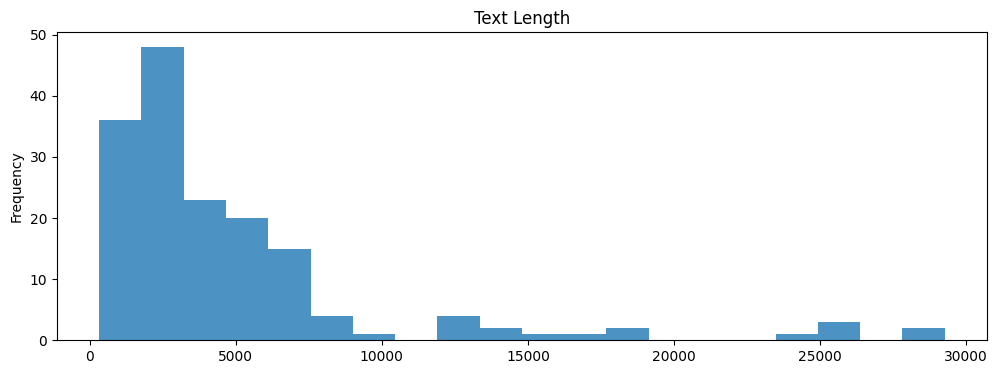

In [46]:
plt.figure(figsize=(12, 4))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.10613685493184996


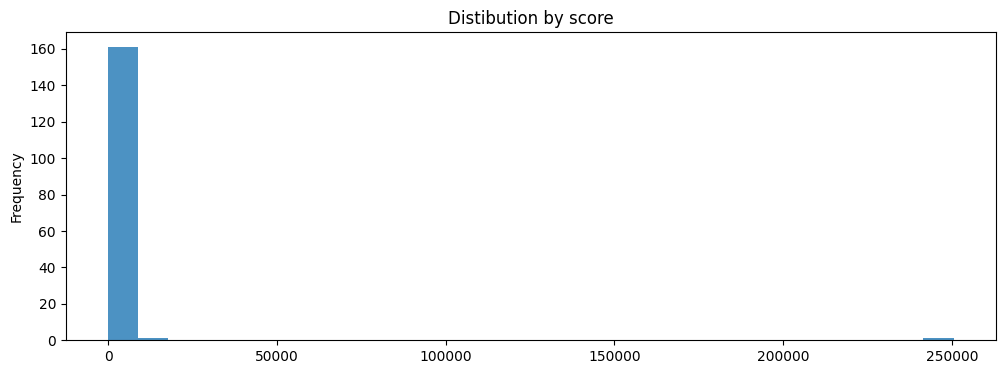

In [47]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 4))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [48]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding docs with rare subj


Service                              61
GeneralContract                      23
Loans                                18
Deal                                 12
Renting                              12
DealIntellectualProperty             11
Charity                               6
SecuritiesTransactions                5
RealEstate                            4
AgencyContract                        4
ParticipationInOtherOrganizations     4
RealEstateTransactions                3
Name: subject, dtype: int64


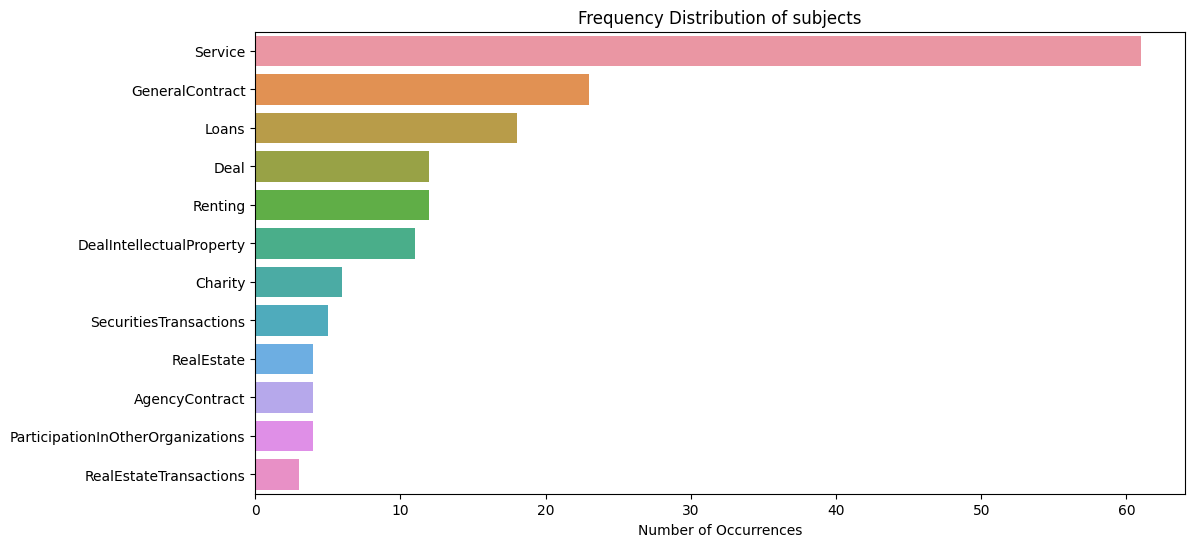

In [49]:
%matplotlib inline
try:
    cnt = dups_s['subject'].value_counts()

    plt.figure(figsize=(12, 6 ))
    sns.barplot(x=cnt.values, y=cnt.index)

    print(  cnt )

    plt.title('Frequency Distribution of subjects')
    plt.xlabel('Number of Occurrences')
    plt.show()
except:
    pass


In [50]:
dups_s.index.name = '_id'
_fn = Path(work_dir) / 'contract_trainset_meta.csv'
dups_s.to_csv(_fn, index=True)
mlflow.log_artifact(_fn)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate:%d.%m.%Y}"
display(Markdown(_s))


dups_s

### 163 - Всего новых документов в обучающем наборе на 23.03.2023

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
643831490fcb1a83bb18add4,RUB,db,78c637561b522949728f0cf6c48f2647,2.4.3,CONTRACT,2023-04-18 09:43:50.341585,2480.0,2021-07-02 14:50:44.851000+00:00,16.0,1.500000e+08,...,1.0,22.0,2022-12-08 18:57:34.163000+00:00,True,125.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.106137,6.627387e+18,1.0
643831490fcb1a83bb18add2,RUB,db,6f2d879b56b1dcad995b240e351b805f,1.6.5,CONTRACT,2023-04-18 09:43:49.751062,2470.0,2020-05-25 07:22:00.471000+00:00,16.0,1.666667e+08,...,0.0,53.0,2020-05-25 07:20:52.034000+00:00,True,119.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.122535,1.077945e+17,1.0
643831490fcb1a83bb18ae2d,RUB,db,5b4cb8bd63a9fdc04e41a8bed71992ee,2.3.14,CONTRACT,2023-04-18 09:43:50.332103,7480.0,2021-01-14 14:29:47.056000+00:00,19.0,8.700080e+07,...,1.0,72.0,2023-01-26 13:41:29.542000+00:00,True,506.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.126893,2.823278e+18,1.0
643831490fcb1a83bb18aef3,RUB,db,6ca3f809785016f578e9f4e6262f9528,2.3.13,CONTRACT,2023-04-18 09:43:49.884505,2670.0,2020-12-23 17:14:30.854000+00:00,11.0,4.384060e+05,...,1.0,83.0,2023-03-06 11:48:04.540000+00:00,True,139.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.292807,4.246326e+18,1.0
643831490fcb1a83bb18ae66,RUB,db,de07c52731121c2e5768a4e17306a12d,2.0.5,CONTRACT,2023-04-18 09:43:49.775160,3380.0,2020-10-23 09:09:01.114000+00:00,12.0,2.423800e+07,...,1.0,26.0,2023-01-27 12:39:03.703000+00:00,True,120.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.353857,-1.724287e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18ae0e,NaN,db,1828544faa8f0f8df11a27e7f0bbfcee,2.5.0,CONTRACT,2023-04-18 09:43:51.488641,5990.0,2021-10-13 16:46:31.470000+00:00,16.0,NaN,...,1.0,72.0,2023-03-01 12:14:36.966000+00:00,True,110.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,8.468468e+18,1.0
643831490fcb1a83bb18ae5e,NaN,db,e10b527db703264371538af74202707f,2.5.0,CONTRACT,2023-04-18 09:43:51.462005,2250.0,2021-10-13 16:26:38.850000+00:00,15.0,NaN,...,1.0,39.0,2021-10-13 13:31:51.249000+00:00,True,101.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,1.317008e+18,1.0
643831490fcb1a83bb18ae60,NaN,db,81e4dfdb4a3992e041ca8a64234ba3ab,2.4.4,CONTRACT,2023-04-18 09:43:50.396126,840.0,2021-08-23 12:19:19.671000+00:00,17.0,NaN,...,1.0,56.0,2021-08-23 09:22:26.623000+00:00,True,126.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,-3.354648e+18,1.0


In [51]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [52]:
dups_s[dups_s['unseen']]

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,


In [53]:
%%time


query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])

_s = f"#### {len(res)} -- Всего документов, которые размечены биочеловеком 🤦"
display(Markdown(_s))


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### 317 -- Всего документов, которые размечены биочеловеком 🤦

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 144 ms


# 🤦 Find markup errors

In [54]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 317


In [55]:
errors_report_file_prefix = "user_markup_errors"
errors_report_metric_prefix = "user"

user_docs_ids = user_docs_ids
%run -i -t {NOTEBOOKS_DIR}/validate_markup.ipynb
del user_docs_ids

DEBUG - 2023-04-18 11:08:31,698 - retrain_ipynb - --=logging started=--


Running on :platform.processor()='x86_64'
documents COLLECTION_NAME='documents_temp'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 317
CPU times: user 11 µs, sys: 8 µs, total: 19 µs
Wall time: 21.5 µs


#### 318.0 -- всего ошибок/недочетов разметки в 317 документах -- (1.003154574132492 на документ)

<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/9c841e5f9621448da49a698fd52cd5f5/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='9c841e5f9621448da49a698fd52cd5f5', run_name='chill-goat-293', run_uuid='9c841e5f9621448da49a698fd52cd5f5', start_time=1681805311709, status='RUNNING', user_id='root'>
see results at
http://192.168.10.38:5000/#/experiments/305219436181214624/runs/9c841e5f9621448da49a698fd52cd5f5


In [56]:




try:
    ax = userdocs.groupby(
        [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
            ['errors count']].count().plot(kind="bar", figsize=(16,3))

    plt.show()
except Exception as e:
    logger.exception(e)
    pass

ERROR - 2023-04-18 11:08:34,535 - retrain_ipynb - Can only use .dt accessor with datetimelike values
Traceback (most recent call last):
  File "/tmp/ipykernel_969171/2145368095.py", line 3, in <module>
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
  File "/root/artem/env/lib/python3.8/site-packages/pandas/core/generic.py", line 5137, in __getattr__
    return object.__getattribute__(self, name)
  File "/root/artem/env/lib/python3.8/site-packages/pandas/core/accessor.py", line 187, in __get__
    accessor_obj = self._accessor(obj)
  File "/root/artem/env/lib/python3.8/site-packages/pandas/core/indexes/accessors.py", line 480, in __new__
    raise AttributeError("Can only use .dt accessor with datetimelike values")
AttributeError: Can only use .dt accessor with datetimelike values


In [57]:

# auto_docs = validate_markup(auto_docs_ids)


# Statistics
### Collecting org types

In [58]:

statistics = {}


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k) for k in l]
c = Counter(l)


statistics['org_types_cased'] = pd.DataFrame(c.items(),  columns = ['type', 'count']).sort_values(['count', 'type'], ascending=False)
statistics['org_types_cased'].to_csv("statistics.org_types_cased.csv")
statistics['org_types_cased']

,type,count
1,Общество с ограниченной ответственностью,404
0,Публичное акционерное общество,71
3,Акционерное общество,51
5,ООО,27
6,ПАО,17
10,общество с ограниченной ответственностью,9
2,nan,9
9,Физическое лицо,7
14,публичное акционерное общество,6
19,акционерное общество,5


In [59]:
l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)


statistics['org_types'] = pd.DataFrame(c.items(),  columns = ['type', 'count']).sort_values(['count', 'type'], ascending=False)
statistics['org_types'].to_csv("statistics.org_types.csv")
statistics['org_types']

,type,count
1,общество с ограниченной ответственностью,415
0,публичное акционерное общество,78
3,акционерное общество,56
5,ооо,27
6,пао,17
2,nan,9
9,физическое лицо,7
10,общества с ограниченной ответственностью,4
17,оао,3
12,ассоциация,3


### Aliases

In [60]:
userdocs['subject kind']

643831490fcb1a83bb18ae3d            AgencyContract
643831490fcb1a83bb18ae45                   Service
643831490fcb1a83bb18ae1d    RealEstateTransactions
643831490fcb1a83bb18ae6c           GeneralContract
643831490fcb1a83bb18ae25                   Service
                                     ...          
643831490fcb1a83bb18ae91           GeneralContract
643831490fcb1a83bb18ae62                   Service
643831490fcb1a83bb18ae61                   Service
643831490fcb1a83bb18ae98                   Service
643831490fcb1a83bb18aed7                   Renting
Name: subject kind, Length: 317, dtype: object

In [61]:
def count_alias_pairs(cased:bool):
    _df = pd.DataFrame()
    for i, v in userdocs.iterrows():
        if cased:
            key = ' & '.join(   np.sort( list([ str(v['Псевдоним 1']), str(v['Псевдоним 2'])])) ) 
        else:
            key = ' & '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 
        key2 = ' & '.join( [str(v['subject kind']), key ] )
        _df.at[i, 'count'] = key2



    _t = pd.DataFrame(_df['count'].value_counts())
    for i, v in _t.iterrows():
        s, a1, a2 = str(i).split('&')
    #     print(a2)
        _t.at[i, 'alias 1'] = a1
        _t.at[i, 'alias 2'] = a2
        _t.at[i, 'subject'] = s
#     statistics['alias_pairs']=_t
#     statistics['alias_pairs'].to_csv("statistics.alias_pair.csv")
#     _t
    return _t


statistics['alias_pairs']=count_alias_pairs(cased=False)
statistics['alias_pairs'].to_csv("statistics.alias_pair.csv")

statistics['alias_pairs_cased']=count_alias_pairs(cased=True)
statistics['alias_pairs_cased'].to_csv("statistics.alias_pair_cased.csv")

In [62]:
statistics['alias_pairs_cased']

,count,alias 1,alias 2,subject
Service & Заказчик & Исполнитель,64,Заказчик,Исполнитель,Service
GeneralContract & Заказчик & Подрядчик,27,Заказчик,Подрядчик,GeneralContract
Renting & Арендатор & Арендодатель,21,Арендатор,Арендодатель,Renting
SecuritiesTransactions & Покупатель & Продавец,13,Покупатель,Продавец,SecuritiesTransactions
Deal & Покупатель & Поставщик,13,Покупатель,Поставщик,Deal
...,...,...,...,...
Charity & Благотворитель & Получатель,1,Благотворитель,Получатель,Charity
Service & Сторона & Сторона,1,Сторона,Сторона,Service
Service & Исполнитель & Компания,1,Исполнитель,Компания,Service
nan & ЗАЕМЩИК & Займодавец,1,ЗАЕМЩИК,Займодавец,nan


In [63]:
statistics['alias_pairs']

,count,alias 1,alias 2,subject
Service & заказчик & исполнитель,75,заказчик,исполнитель,Service
GeneralContract & заказчик & подрядчик,33,заказчик,подрядчик,GeneralContract
Renting & арендатор & арендодатель,21,арендатор,арендодатель,Renting
SecuritiesTransactions & покупатель & продавец,13,покупатель,продавец,SecuritiesTransactions
Deal & покупатель & поставщик,13,покупатель,поставщик,Deal
Loans & заемщик & займодавец,12,заемщик,займодавец,Loans
Loans & заемщик & кредитор,12,заемщик,кредитор,Loans
Loans & банк & заявитель,11,банк,заявитель,Loans
Service & заказчик & подрядчик,10,заказчик,подрядчик,Service
ParticipationInOtherOrganizations & покупатель & продавец,10,покупатель,продавец,ParticipationInOtherOrganizations


## Validate auto markup

In [64]:
del userdocs
auto_docs_ids = stats[ (stats.user_correction_date.isnull()) & (stats.source=='db') & (stats['documentType']=='CONTRACT') ].index
errors_report_file_prefix = "ai_markup_errors"
errors_report_metric_prefix = "ai"
user_docs_ids = auto_docs_ids
%run -i -t {NOTEBOOKS_DIR}/validate_markup.ipynb
del user_docs_ids

auto_docs = userdocs

DEBUG - 2023-04-18 11:08:34,889 - retrain_ipynb - --=logging started=--
DEBUG - 2023-04-18 11:08:34,889 - retrain_ipynb - --=logging started=--


Running on :platform.processor()='x86_64'
documents COLLECTION_NAME='documents_temp'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 0
CPU times: user 14 µs, sys: 7 µs, total: 21 µs
Wall time: 22.2 µs


/tmp/ipykernel_969171/406872241.py:5: RuntimeWarning: invalid value encountered in long_scalars
  _s = f"#### {userdocs['errors count'].sum()} -- всего ошибок/недочетов разметки в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs)} на документ)"


#### 0 -- всего ошибок/недочетов разметки в 0 документах -- (nan на документ)

<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/6a3253329f8b49b8b824eb37b11b997e/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='6a3253329f8b49b8b824eb37b11b997e', run_name='bemused-snake-808', run_uuid='6a3253329f8b49b8b824eb37b11b997e', start_time=1681805314902, status='RUNNING', user_id='root'>
see results at
http://192.168.10.38:5000/#/experiments/305219436181214624/runs/6a3253329f8b49b8b824eb37b11b997e


/tmp/ipykernel_969171/2083360429.py:11: RuntimeWarning: invalid value encountered in long_scalars
  mlflow.log_metric(f'severity per doc', userdocs['errors severity'].sum()/len(userdocs))
/tmp/ipykernel_969171/2083360429.py:14: RuntimeWarning: invalid value encountered in long_scalars
  mlflow.log_metric(f'errors per doc', userdocs['errors count'].sum()/len(userdocs))


### Invalidate no-date docs

In [65]:
bad_docs = auto_docs[ (auto_docs['Дата'].isnull()) | (auto_docs['errors severity']>=10)]
bad_docs.index

for i, row in stats.iterrows():
    if i in bad_docs.index:
        stats.at[i, 'valid'] = False
# stats.loc[bad_docs.index].valid=False
stats.loc[bad_docs.index].valid
# for i, row in stats.iterrows():
#     if i

Series([], Name: valid, dtype: bool)

In [66]:
good_docs = auto_docs[ (~auto_docs['Дата'].isnull()) & (auto_docs['errors severity']<10)]
good_docs
# auto_docs[auto_docs['errors count']<3]

,errors count,errors severity,дата редактирования,Дата


# Make datapoints

In [67]:
work_dir

PosixPath('/root/artem/work')

In [68]:



embedder = ElmoEmbedder.get_instance('elmo')  # lazy init


from retrain_contract_uber_model import save_contract_data_arrays

if False: #TODO clean it up, this code moved to .py
    def _dp_fn(doc_id, suffix):
        return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


    def save_contract_data_arrays(db_json_doc: DbJsonDoc):
        # TODO: trim long documens according to contract parser

        id_ = db_json_doc.get_id()

        tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

        # 1) EMBEDDINGS
        print(len(tokens_map))
        embeddings = embedd_tokens(tokens_map,
                                   embedder,
                                   log_key=f'id={id_} chs={tokens_map.get_checksum()}')

        # 2) TOKEN FEATURES
        token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

        # 3) SEMANTIC MAP
        semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
        #####

        np.save(_dp_fn(id_, 'token_features'), token_features)
        np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
        _embeddings_file = _dp_fn(id_, 'embeddings')
        np.save(_embeddings_file, embeddings)
        print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


In [69]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)

1

In [70]:
# good_docs.index

# intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 

### Trainset fixtures
#### Invalidate long subjects

In [71]:
%%time

ids = list(dups_s.index)


if not 'subject_pos' in stats:
    stats['subject_pos'] = None
        
ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_from_db_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len  
            
            stats.at[_id, 'subject_pos'] = span[0]
            dups_s.at[_id, 'subject_pos'] = span[0]  
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
# stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


CPU times: user 685 ms, sys: 58.1 ms, total: 743 ms
Wall time: 1.06 s


#### Fix missing headers

In [72]:
%%time




def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()[COLLECTION_NAME]
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k, oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_from_db_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


CPU times: user 555 ms, sys: 56.5 ms, total: 611 ms
Wall time: 926 ms


In [73]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [74]:
len(ids_of_long_subject_docs)

0

In [75]:
dups_s

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
643831490fcb1a83bb18add4,RUB,db,78c637561b522949728f0cf6c48f2647,2.4.3,CONTRACT,2023-04-18 09:43:50.341585,2480.0,2021-07-02 14:50:44.851000+00:00,16.0,1.500000e+08,...,1.0,22.0,2022-12-08 18:57:34.163000+00:00,True,125.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.106137,6.627387e+18,1.0
643831490fcb1a83bb18add2,RUB,db,6f2d879b56b1dcad995b240e351b805f,1.6.5,CONTRACT,2023-04-18 09:43:49.751062,2470.0,2020-05-25 07:22:00.471000+00:00,16.0,1.666667e+08,...,0.0,53.0,2020-05-25 07:20:52.034000+00:00,True,119.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.122535,1.077945e+17,1.0
643831490fcb1a83bb18ae2d,RUB,db,5b4cb8bd63a9fdc04e41a8bed71992ee,2.3.14,CONTRACT,2023-04-18 09:43:50.332103,7480.0,2021-01-14 14:29:47.056000+00:00,19.0,8.700080e+07,...,1.0,72.0,2023-01-26 13:41:29.542000+00:00,True,506.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.126893,2.823278e+18,1.0
643831490fcb1a83bb18aef3,RUB,db,6ca3f809785016f578e9f4e6262f9528,2.3.13,CONTRACT,2023-04-18 09:43:49.884505,2670.0,2020-12-23 17:14:30.854000+00:00,11.0,4.384060e+05,...,1.0,83.0,2023-03-06 11:48:04.540000+00:00,True,139.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.292807,4.246326e+18,1.0
643831490fcb1a83bb18ae66,RUB,db,de07c52731121c2e5768a4e17306a12d,2.0.5,CONTRACT,2023-04-18 09:43:49.775160,3380.0,2020-10-23 09:09:01.114000+00:00,12.0,2.423800e+07,...,1.0,26.0,2023-01-27 12:39:03.703000+00:00,True,120.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,0.353857,-1.724287e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643831490fcb1a83bb18ae0e,NaN,db,1828544faa8f0f8df11a27e7f0bbfcee,2.5.0,CONTRACT,2023-04-18 09:43:51.488641,5990.0,2021-10-13 16:46:31.470000+00:00,16.0,NaN,...,1.0,72.0,2023-03-01 12:14:36.966000+00:00,True,110.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,8.468468e+18,1.0
643831490fcb1a83bb18ae5e,NaN,db,e10b527db703264371538af74202707f,2.5.0,CONTRACT,2023-04-18 09:43:51.462005,2250.0,2021-10-13 16:26:38.850000+00:00,15.0,NaN,...,1.0,39.0,2021-10-13 13:31:51.249000+00:00,True,101.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,1.317008e+18,1.0
643831490fcb1a83bb18ae60,NaN,db,81e4dfdb4a3992e041ca8a64234ba3ab,2.4.4,CONTRACT,2023-04-18 09:43:50.396126,840.0,2021-08-23 12:19:19.671000+00:00,17.0,NaN,...,1.0,56.0,2021-08-23 09:22:26.623000+00:00,True,126.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6438...,False,8848.658197,-3.354648e+18,1.0


In [76]:
stats.to_csv(export_fn, index=True)
mlflow.log_artifact(export_fn)

# Main sequence

In [77]:
%%time

from IPython.display import clear_output

# raise('test mode!')

# enumerate(list(intersection_set))
for k, oid in enumerate(ids): 
# for k, oid in enumerate(list(ids)):
    if k % 20 == 0:
        clear_output(wait=True)
        
# 
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_from_db_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


643831490fcb1a83bb18ae60 160 of 163 db
840
fixed number: ['№ __________________________________________________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/643831490fcb1a83bb18ae60-datapoint-embeddings.npy (840, 1024)
643831490fcb1a83bb18ae8d 161 of 163 db
5567
fixed number: ['№ 1234'] -->  ['1234']
embeddings saved to /root/artem/work/datasets/643831490fcb1a83bb18ae8d-datapoint-embeddings.npy (5567, 1024)
643831490fcb1a83bb18ae8e 162 of 163 db
5556
fixed number: ['№ 1234'] -->  ['1234']
embeddings saved to /root/artem/work/datasets/643831490fcb1a83bb18ae8e-datapoint-embeddings.npy (5556, 1024)
CPU times: user 12.3 s, sys: 2.05 s, total: 14.4 s
Wall time: 14.9 s


In [78]:
print('see results at')
print(f'{mlflow.get_registry_uri()}/#/experiments/{mlflow.last_active_run().info.experiment_id}/runs/{mlflow.last_active_run().info.run_id}')

see results at
http://192.168.10.38:5000/#/experiments/273381584422389923/runs/9f4f02b7e0624c6c9fae2d8e438c3d4d
